In [84]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import wandb

In [85]:
class TitanicDataset(Dataset):
    # X랑 y 받아서 Tensor로 변환
    def __init__(self, X, y):
        # FloatTensor로 바꿈
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    # 데이터셋 크기 반환
    def __len__(self):
        return len(self.X)
    
    # 인덱스 받아서 데이터 하나씩 출력
    def __getitem__(self, idx):
        feature = self.X[idx]
        target = self.y[idx]
        return {'input': feature, 'target': target}
    
    # 데이터셋 정보 문자열로 반환 
    def __str__(self):
        str = "data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(len(self.X), self.X.shape, self.y.shape)
        return str


In [86]:
class TitanicTestDataset(Dataset):
    # Tensor로 변환
    def __init__(self, X):
        self.X = torch.FloatTensor(X)
    
    # 데이터 개수 반환
    def __len__(self):
        return len(self.X)
    
    # 인덱스 받아서 데이터 출력
    def __getitem__(self, idx):
        feature = self.X[idx]
        return {'input': feature}
    
    # 데이터셋 정보 문자열로 반환
    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}".format(
            len(self.X), self.X.shape
        )
        return str


In [87]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df


def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df


def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df


def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df


def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df


def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df


In [88]:
def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.getcwd()

    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset

In [89]:
from torch import nn
# 모델 정의 및 최적 activation 찾기
class MyModel(nn.Module):
    def __init__(self, n_input, n_output, activation_fn=nn.ReLU):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 30),
            activation_fn(),  # activation_fn을 호출하여 인스턴스를 생성
            nn.Linear(30, 30),
            activation_fn(),  # activation_fn을 호출하여 인스턴스를 생성
            nn.Linear(30, n_output),
        )

    def forward(self, x):
        return self.model(x)

In [90]:
# 테스트 함수
def test(test_data_loader, model):
    print("[TEST]")
    batch = next(iter(test_data_loader))
    print("{0}".format(batch['input'].shape))
    output_batch = model(batch['input'])
    prediction_batch = torch.argmax(output_batch, dim=1)
    for idx, prediction in enumerate(prediction_batch, start=892):
        print(idx, prediction.item())

In [94]:
# 제출 파일 생성 함수
def create_submission(test_data_loader, model, submission_file='/home/Deep-Learning-study/_02_homeworks/hw2/submission.csv'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_data_loader:
            outputs = model(batch['input'])
            prediction_batch = torch.argmax(outputs, dim=1)
            predictions.extend(prediction_batch.cpu().numpy())

    # 지정된 경로에 submission.csv 파일 생성
    submission_df = pd.DataFrame({'PassengerId': range(892, 892 + len(predictions)), 'Survived': predictions})
    
    # 디렉토리 확인 및 생성
    directory = os.path.dirname(submission_file)
    if not os.path.exists(directory):
        os.makedirs(directory)

    submission_df.to_csv(submission_file, index=False)
    print(f"Submission file '{submission_file}' created.")

In [95]:
# 학습 및 검증 함수
def train_and_validate(train_data_loader, validation_data_loader, model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        # Training loop
        for batch in train_data_loader:
            optimizer.zero_grad()
            outputs = model(batch['input'])
            loss = criterion(outputs, batch['target'])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_data_loader)

        # Validation loop
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for batch in validation_data_loader:
                outputs = model(batch['input'])
                loss = criterion(outputs, batch['target'])
                validation_loss += loss.item()

        validation_loss /= len(validation_data_loader)

        # Log losses to wandb
        wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "validation_loss": validation_loss})
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")

In [96]:
# 메인 함수
if __name__ == "__main__":
    wandb.init(project="titanic-pytorch")
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

    print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
        len(train_dataset), len(validation_dataset), len(test_dataset)
    ))

    # 데이터 로더 설정
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=False)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

    # 모델 및 손실 함수, 최적화기 초기화
    my_model = MyModel(n_input=11, n_output=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)

    # 학습 및 검증
    num_epochs = 10
    train_and_validate(train_data_loader, validation_data_loader, my_model, criterion, optimizer, num_epochs)

    # 제출 파일 생성
    create_submission(test_data_loader, my_model)

    # wandb 종료
    wandb.finish()

/tmp/ipykernel_1011/1050572811.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
/tmp/ipykernel_1011/1050572811.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
Epoch [1/10], Train Loss: 0.8741, Validation Loss: 0.6960
Epoch [2/10], Train Loss: 0.5993, Validation Loss: 0.6275
Epoch [3/10], Train Loss: 0.5847, Validation Loss: 0.6462
Epoch [4/10], Train Loss: 0.5714, Validation Loss: 0.6157
Epoch [5/10], Train Loss: 0.5542, Validation Loss: 0.6489
Epoch [6/10], Train Loss: 0.5604, Validation Loss: 0.5910
Epoch [7/10], Train Loss: 0.5524, Validation Loss: 0.5934
Epoch [8/10], Train Loss: 0.5442, Validation Loss: 0.5866
Epoch [9/10], Train Loss: 0.5298, Validation Loss: 0.5964
Epoch [10/10], Train Loss: 0.5308, Validation Loss: 0.5862
Submission file '/home/Deep-Learning-study/_02_homeworks/hw2/submission.csv' created.


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▂▁▂▁▁▁▁
validation_loss,█▄▅▃▅▁▁▁▂▁
epoch,10
train_loss,0.53079
validation_loss,0.58621


In [ ]:
# 실제 총 학습의 전 과정을 대략적으로 경험할 수 있던 시간이어서 유익한 시간이었습니다.

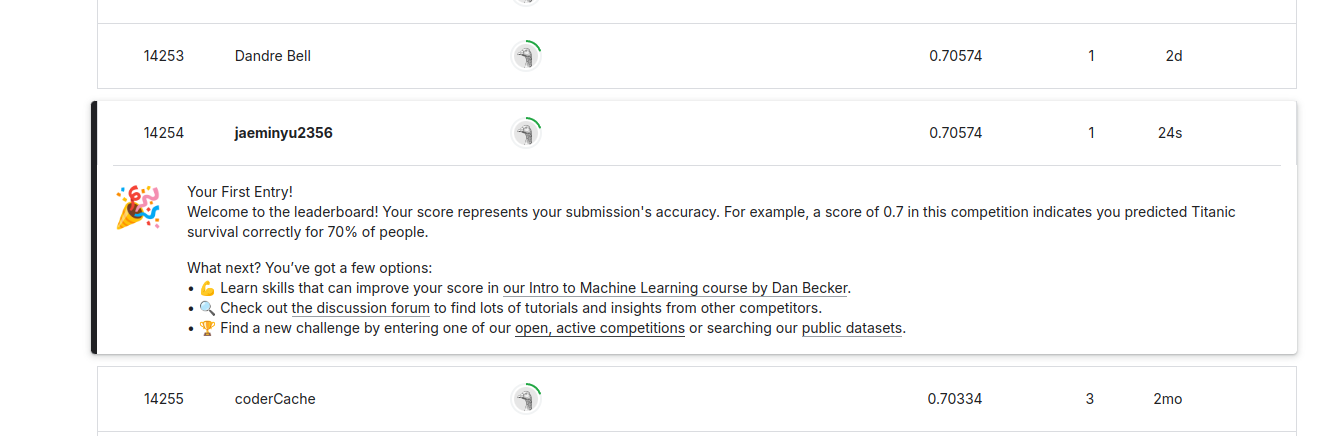